In [89]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 加上一个 EOS 标记

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读入文件 filename, 分行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 建立一个列表存储名字
lines = []
for filename in findFiles('dota/*.txt'):
    filelines = readLines(filename)
    lines += filelines


In [90]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# input 的 one-hot编码 ，从第一个字母到最后一个字母（不包含 EOS）
def inputTensor(line):
    '''
    Converts the input string into the corresponding 3D tensor
    '''
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor.to(device)

# output 的 one-hot编码 ，从第二个字母到最后的 EOS 符
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li])for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) # EOS的索引
    return torch.LongTensor(letter_indexes).to(device)

cuda:0


In [91]:
import random

# 随机抽样
def randomChoice(l):
    '''
    Select a random element from the array l
    '''
    return l[random.randint(0,len(l)-1)]

# input 的 tensor, 和 target 的 tensors 
def randomTrainingExample(lines):
    line = randomChoice(lines)
    input_line_tensor = inputTensor(line)   # 输入name的one-hot矩阵
    target_line_tensor = targetTensor(line) # 标签矩阵 [14,  2,  7,  4, 17, 58]
    
    # the one-hot encoding of the string
    # The index vector of each character in the string in the all_letters list
    return input_line_tensor, target_line_tensor


In [92]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN,self).__init__() 
        self.hidden_size = hidden_size
        self.input_size = input_size

        #    Initialize the weight matrix
        # 使用nn.Parameter来定义需要优化的权重
        self.W = nn.Parameter(torch.rand(hidden_size, hidden_size) * 0.01)
        self.U = nn.Parameter(torch.rand(input_size, hidden_size) * 0.01)
        self.b = nn.Parameter(torch.rand(hidden_size) * 0.01)

    def forward(self, input, hidden):
        hidden = torch.matmul(hidden, self.W) + \
            torch.matmul(input, self.U) + self.b
        hidden = torch.tanh(hidden)

        return hidden

In [93]:
import torch.nn as nn

class BiRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(BiRNN,self).__init__()
        self.hidden_size = hidden_size 

        #    Initialize the weight matrix
        # 使用nn.Parameter来定义需要优化的权重
        self.V = nn.Parameter(torch.rand(hidden_size * 2, output_size) * 0.01)
        self.c = nn.Parameter(torch.rand(output_size) * 0.01)
        
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden1, hidden2):
        # 最终的输出是正向和反向隐藏状态的拼接
        output = torch.cat((hidden1, hidden2), dim=1)
        output = torch.matmul(output, self.V) + self.c
        
        output = self.dropout(output)
        output = self.softmax(output)

        return output
    
    def initHiddens(self):
        return torch.zeros(1,self.hidden_size).to(device), \
                torch.zeros(1,self.hidden_size).to(device)

In [94]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(birnn, rnn1, rnn2, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden1, hidden2 = birnn.initHiddens()

    # 保存所有时刻的隐藏层
    birnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        hidden1 = rnn1(input_line_tensor[i], hidden1)

    for i in reversed(range(input_line_tensor.size(0))):
        hidden2 = rnn2(input_line_tensor[i], hidden2)

    for i in range(input_line_tensor.size(0)):
        output = birnn(hidden1, hidden2)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in birnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    for p in rnn1.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    for p in rnn2.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [95]:
def progress(num):
    p = int(num / 5)
    s = '[' + '#'*p + '-'*(20-p)  + ']'
    return s

import time

def timeSince(since):
    now = time.time()
    s = now-since
    return '%dm %ds'%(s//60,s%60)

n_iters = 100000
print_every = 5000
plot_every = 500

all_losses = []
total_loss = 0

# The size of the hidden layer
n_hidden = 128
# 创建了一个BiRNN模型
# 输入维度为n_letters 隐藏层维度为n_hidden 输出维度为n_letters
birnn = BiRNN(n_hidden, n_letters)
birnn = birnn.to(device)

rnn1 = RNN(n_letters, n_hidden)
rnn1 = rnn1.to(device)

rnn2 = RNN(n_letters, n_hidden)
rnn2 = rnn2.to(device)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(birnn, rnn1, rnn2, *randomTrainingExample(lines))
    total_loss += loss

    if iter % print_every == 0:
        s = '%s %.4f' % (timeSince(start), loss)
        s += progress(iter/n_iters*100)
        print(s)
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0


0m 37s 3.2765[#-------------------]
1m 11s 2.8569[##------------------]
1m 44s 2.7658[###-----------------]
2m 19s 3.4537[####----------------]
2m 57s 2.7149[#####---------------]
3m 31s 2.8837[######--------------]
4m 5s 2.9906[#######-------------]
4m 39s 3.0733[########------------]
5m 13s 3.2819[#########-----------]
5m 46s 2.9883[##########----------]
6m 22s 3.3022[###########---------]
6m 58s 2.7234[############--------]
7m 32s 3.3674[#############-------]
8m 6s 2.8682[##############------]
8m 39s 2.6464[###############-----]
9m 12s 3.3758[################----]
9m 45s 3.3031[#################---]
10m 19s 3.2042[##################--]
10m 54s 2.9471[###################-]
11m 33s 2.9494[####################]


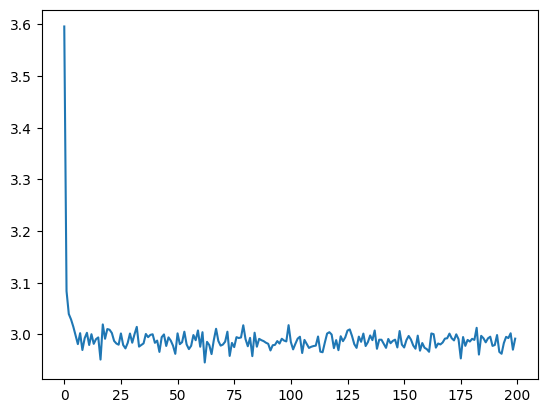

In [96]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [97]:
def split_string(string): return [char for char in string]

In [98]:
max_length = 20
def build_name(start_string = 'A'):
    #   Top five predictions for each moment
    input_num = len(start_string)
    letters = split_string(start_string)
    preds = [[i] for i in letters]
    num = len(letters)

    with torch.no_grad():

        inputs = [inputTensor(i) for i in letters]
        hidden1, hidden2 = birnn.initHiddens()
        
        # Initialize the output name as the starting letter
        output_name = start_string

        for i in range(max_length):
            if i < num :
                input = inputs[i]
            hidden1 = rnn1(input[0], hidden1)
            hidden2 = rnn2(input[0], hidden2)
            output = birnn(hidden1, hidden2)
            

            if i + 1 < num :
                #   如果还有字符等待处理
                pass
            else:
                #   如果字符已经处理完毕
        
                _, topi = output.topk(5)
                topi = topi[0]

                topi1 = topi[0]
                if topi1 == n_letters - 1 :
                    break
                else:
                    letter = all_letters[topi1]
                    output_name += letter

                    topi = [all_letters[i] if i < len(all_letters) else 'EOS' for i in topi]
                    
                    preds.append(topi)
                    
                input = inputTensor(letter)

    return output_name, preds, input_num

In [99]:
def draw(output_name, data, input_num):
    ''' Map the prediction process '''
    # Preprocess the input list named data
    for i in range(input_num):
        for j in range(4):
            data[i].append(' ')

    print('------  ========  ------\n')
    print(f'The final name is {output_name}\n')
    print('------  ========  ------\n')
    num_data = len(data)
    line1 = '=====\t' * (num_data + 1) +'\n'
    _line2 = ''
    for j in range(5):
        for i in range(num_data):
            if j > 0 :
                if data[i][j] != 'EOS':
                    _line2 += '  x  \t'.replace('x', data[i][j])
                else:
                    _line2 += '  x  \t'.replace(' x ', data[i][j])
            else:
                if data[i][j] != 'EOS':
                    _line2 += '  x   > '.replace('x', data[i][j])
                else:
                    _line2 += '  x   > '.replace(' x ', data[i][j])

                if i == num_data - 1 :
                    _line2 += ' EOS '
                
        _line2 += '\n'
        

    print(line1)
    print(_line2)
    print(line1)
    

In [100]:
input_chars = 'Ro'
draw(*build_name(input_chars))

------  ========  ------

The final name is Ro

------  ========  ------

=====	=====	=====	

  R   >   o   >  EOS 
     	     	
     	     	
     	     	
     	     	

=====	=====	=====	

